In [1]:
import requests

# 'type': 'Line',
#     'lineWidth': 3,
#     'hide': False,
#     'min': 0,
#     'name': 'South Branch-',
#     'subType': 'Basic',

headers = {
    'authority': 'dvlzjowx88.execute-api.us-west-2.amazonaws.com',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
    'sec-ch-ua-platform': '"macOS"',
    'accept': '*/*',
    'origin': 'https://s3.us-east-2.amazonaws.com',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://s3.us-east-2.amazonaws.com/',
    'accept-language': 'en-US,en;q=0.9',
}

response = requests.get('https://dvlzjowx88.execute-api.us-west-2.amazonaws.com/h2now/all-branches/bacteria/latest', headers=headers)

In [2]:
db = response.json()

In [3]:
Northbranch = db["data"]["dataModel"]["data"][0]["values"]
Southbranch = db["data"]["dataModel"]["data"][1]["values"]
MainStem = db["data"]["dataModel"]["data"][2]["values"]

In [4]:
import pandas as pd
nbdata = pd.DataFrame(columns = ["date","timeOfSample", "ppm"])
sbdata = pd.DataFrame()
msdata = pd.DataFrame()

for i in range(len(Northbranch)):
    nbdata = nbdata.append({"date":Northbranch[i]["timeOfSample"].split("T")[0], "timeOfSample": Northbranch[i]["timeOfSample"].split("T")[1].split(".")[0], "ppm": Northbranch[i]["value"]}, ignore_index=True)
    
    
for j in range(len(Southbranch)):
    sbdata = sbdata.append({"date":Southbranch[j]["timeOfSample"].split("T")[0], "timeOfSample": Southbranch[j]["timeOfSample"].split("T")[1].split(".")[0], "ppm": Southbranch[j]["value"]}, ignore_index=True)
    
for k in range(len(MainStem)):
    msdata = msdata.append({"date":MainStem[k]["timeOfSample"].split("T")[0], "timeOfSample": MainStem[k]["timeOfSample"].split("T")[1].split(".")[0], "ppm": MainStem[k]["value"]}, ignore_index=True)




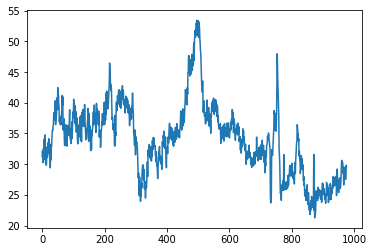

In [5]:
import matplotlib.pyplot as plt

y = list(sbdata["ppm"])
x = range(len(sbdata))

plot = plt.plot(x,y)
plot

In [ ]:
#this is something that i